# Post-Processing Statistical Models in Chapter 7

This notebook processes the brms/stan output and creates the figures used in this chapter. Generally, everything is pretty similar to the previous results. However, the estimation did change a little bit. The quadratic specification made some of my code break. I ended up changing things to a multilevel model. Throughout the analysis:

* I estimated a latent variable of authoritarianism. It doesn't matter, but for consistency with Stanley's latent variable analysis, it seemed wise.
* Multinomial logit models.

In [63]:
### Load dependencies, data, themes, configurations
rm(list = ls())
#require(c("tidyverse", "tidybayes", "broom", "lavaan", "cowplot", "readstata13", "foreign", "car", "modelr"))
### useful functinon to 0-1 recode
zero.one<-function(x){
  min.x<-min(x, na.rm=T)
  max.x<-max(x-min.x, na.rm=T)
  return((x-min.x)/max.x)
}

library(brms)
library(ggplot2)
library(modelr)
library(tidybayes)
library(dplyr)
library(cowplot)
library(haven)
library(forcats)
library(tidyr)

## Some helper functions, and configurations.
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_V2/clean_data/panel.auth.rda")  ### Just work from this data; everything should be here, recoded.
## models
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_V2/clean_data/chapter7.rda")
dat2000 = tmp_data[[4]] 
dat2012 = tmp_data[[5]] 
dat2016 = tmp_data[[6]] 


In [65]:
ggtheme = theme(
        plot.title=element_text(face="bold",hjust=0,vjust=0,colour="#3C3C3C",size=20),
        axis.text.x=element_text(size=16,colour="#535353",face="bold"),
        axis.text.y=element_text(size=16,colour="#535353",face="bold"),
        axis.title = element_text(size=16,colour="#535353",face="bold"),
        axis.title.y=element_text(size=16,colour="#535353",face="bold",vjust=1.5),
        axis.ticks=element_blank(),
        strip.text.x = element_text(size = 16),
        panel.grid.major=element_line(colour="#D0D0D0",size=.25),
        panel.background=element_rect(fill="white"),
        legend.text=element_text(size=14),
        legend.title=element_text(size=16)) 
## Voting transitions
table(dat2000$vote1, dat2000$vote2) %>% prop.table(1)
table(dat2012$vote1, dat2012$vote2) %>% prop.table(1)
table(dat2016$vote1, dat2016$vote2) %>% prop.table(1)

## Voting transitions
table(dat2000$pid3.1, dat2000$pid3.2) %>% prop.table(1)
table(dat2012$pid3.1, dat2012$pid3.2) %>% prop.table(1)
table(dat2016$pid3.1, dat2016$pid3.2) %>% prop.table(1)

   
            0         1
  0 0.8636364 0.1363636
  1 0.0609319 0.9390681

   
             0          1
  0 0.91259436 0.08740564
  1 0.04540461 0.95459539

   
             0          1
  0 0.95734597 0.04265403
  1 0.06611570 0.93388430

   
             1          2          3
  1 0.89268293 0.08292683 0.02439024
  2 0.14615385 0.60769231 0.24615385
  3 0.01276596 0.14042553 0.84680851

   
             1          2          3
  1 0.87362637 0.08741259 0.03896104
  2 0.11269488 0.77371938 0.11358575
  3 0.01608849 0.12217195 0.86173957

   
             1          2          3
  1 0.80131363 0.12972085 0.06896552
  2 0.12873862 0.63459038 0.23667100
  3 0.04178273 0.13649025 0.82172702

# Party Identification Models

In [4]:
dat[[4]]%>% as.formula
dat[[5]]%>% as.formula
dat[[6]]%>% as.formula

pid3.2 ~ sex.2000 + age.2000 + college.2000 + income.2000 + authoritarianism + authoritarianism_2 + republican + independent + authoritarianism:republican + authoritarianism_2:republican + authoritarianism:independent + authoritarianism_2:independent 

pid3.2 ~ sex.2012 + sex.2012 + college.2012 + income.2012 + authoritarianism + authoritarianism_2 + republican + independent + authoritarianism:republican + authoritarianism_2:republican + authoritarianism:independent + authoritarianism_2:independent 

pid3.2 ~ female.2016 + age.2016 + college.2016 + income.2016 + authoritarianism + authoritarianism_2 + republican + independent + authoritarianism:republican + authoritarianism_2:republican + authoritarianism:independent + authoritarianism_2:independent 

`summarise()` has grouped output by 'outcome', 'Authoritarianism'. You can
override using the `.groups` argument.


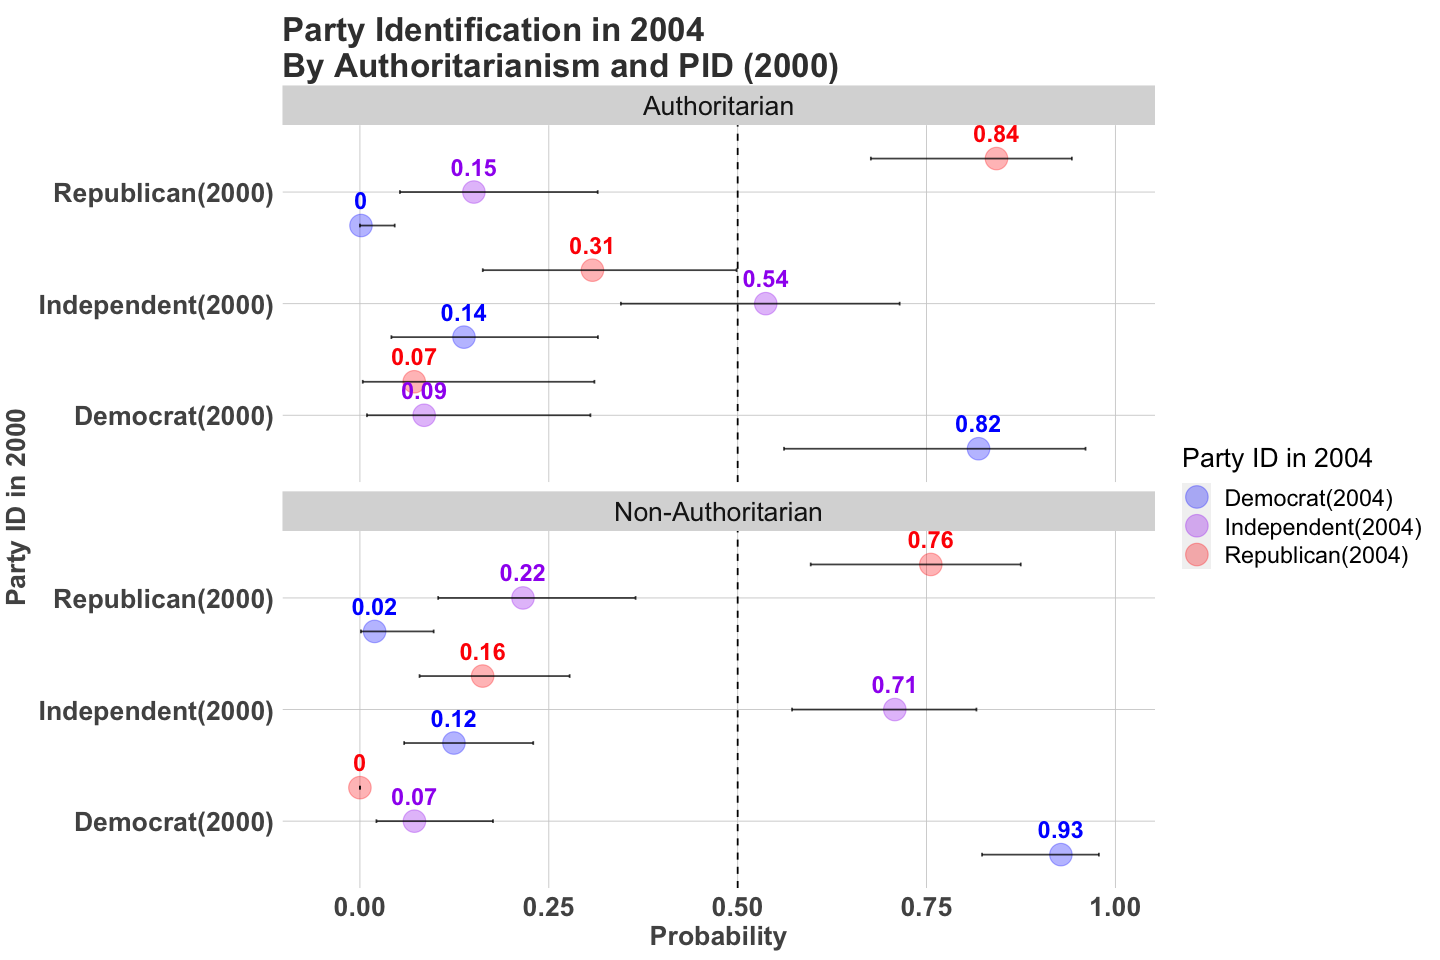

In [5]:
options(repr.plot.width=12, repr.plot.height=8)

zap_labels(dat2000) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2000 = mean(sex.2000, na.rm = T), 
            age.2000 = mean(age.2000, na.rm = T), 
            college.2000 = mean(college.2000, na.rm = T), 
            income.2000 = mean(income.2000, na.rm = T), 
            authoritarianism = seq_range(authoritarianism, n = 2),
            republican = c(0,1),
            independent =c(0,1)) %>% 
                                  filter(!(republican ==1 & independent ==1)) %>% 

                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_epred_draws(dat[[4]]) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(outcome = recode(.category, `1` = "Democrat(2004)", `2` = "Independent(2004)", `3` = "Republican(2004)")) %>%
                       mutate(Partisanship = ifelse(republican == 0 & independent ==0, "Democrat(2000)", 
                                                ifelse(republican ==1 & independent ==0, "Republican(2000)",
                                                    "Independent(2000)")))  %>%
                       group_by(outcome, Authoritarianism, Partisanship) %>% 
                      summarize(mean = quantile(.epred, prob =  0.5),
                                min  = quantile(.epred, prob = 0.025),
                                max  = quantile(.epred, prob = 0.975)) %>% 
 ggplot(aes(x = as.factor(Partisanship), 
                  y = mean, ymin=max, 
                  colour = outcome,
                  group = outcome,
                  ymax=min, label = round(mean,2)))+
facet_wrap(~ as.factor(Authoritarianism) , nrow = 4) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
  ggtitle("Party Identification in 2004\nBy Authoritarianism and PID (2000)") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("Party ID in 2000") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Party ID in 2004", values=c("blue", "purple", "red")) +
  coord_flip()     

In [6]:
zap_labels(dat2000) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2000 = mean(sex.2000, na.rm = T), 
            age.2000 = mean(age.2000, na.rm = T), 
            college.2000 = mean(college.2000, na.rm = T), 
            income.2000 = mean(income.2000, na.rm = T), 
            authoritarianism = seq_range(authoritarianism, n = 2),
            republican = c(0,1),
            independent =c(0,1)) %>% 
                                  filter(!(republican ==1 & independent ==1)) %>% 

                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_epred_draws(dat[[4]]) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(outcome = recode(.category, `1` = "Democrat(2004)", `2` = "Independent(2004)", `3` = "Republican(2004)")) %>%
                       mutate(Partisanship = ifelse(republican == 0 & independent ==0, "Democrat(2000)", 
                                                ifelse(republican ==1 & independent ==0, "Republican(2000)",
                                                    "Independent(2000)")))  %>%
                       group_by(outcome, Authoritarianism, Partisanship) %>% 
                      summarize(mean = quantile(.epred, prob =  0.5),
                                min  = quantile(.epred, prob = 0.025),
                                max  = quantile(.epred, prob = 0.975)) 

`summarise()` has grouped output by 'outcome', 'Authoritarianism'. You can
override using the `.groups` argument.


outcome,Authoritarianism,Partisanship,mean,min,max
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Democrat(2004),Authoritarian,Democrat(2000),8.188414e-01,5.613291e-01,9.604527e-01
Democrat(2004),Authoritarian,Independent(2000),1.377343e-01,4.165208e-02,3.150869e-01
Democrat(2004),Authoritarian,Republican(2000),1.419533e-03,3.332864e-07,4.606093e-02
Democrat(2004),Non-Authoritarian,Democrat(2000),9.278318e-01,8.234599e-01,9.781503e-01
Democrat(2004),Non-Authoritarian,Independent(2000),1.244553e-01,5.853839e-02,2.294414e-01
Democrat(2004),Non-Authoritarian,Republican(2000),1.943764e-02,1.336704e-03,9.763251e-02
Independent(2004),Authoritarian,Democrat(2000),8.504932e-02,9.324432e-03,3.050994e-01
Independent(2004),Authoritarian,Independent(2000),5.371444e-01,3.454126e-01,7.144096e-01
Independent(2004),Authoritarian,Republican(2000),1.508655e-01,5.296085e-02,3.147459e-01


# The 2012-2016 Data

`summarise()` has grouped output by 'outcome', 'Authoritarianism'. You can
override using the `.groups` argument.


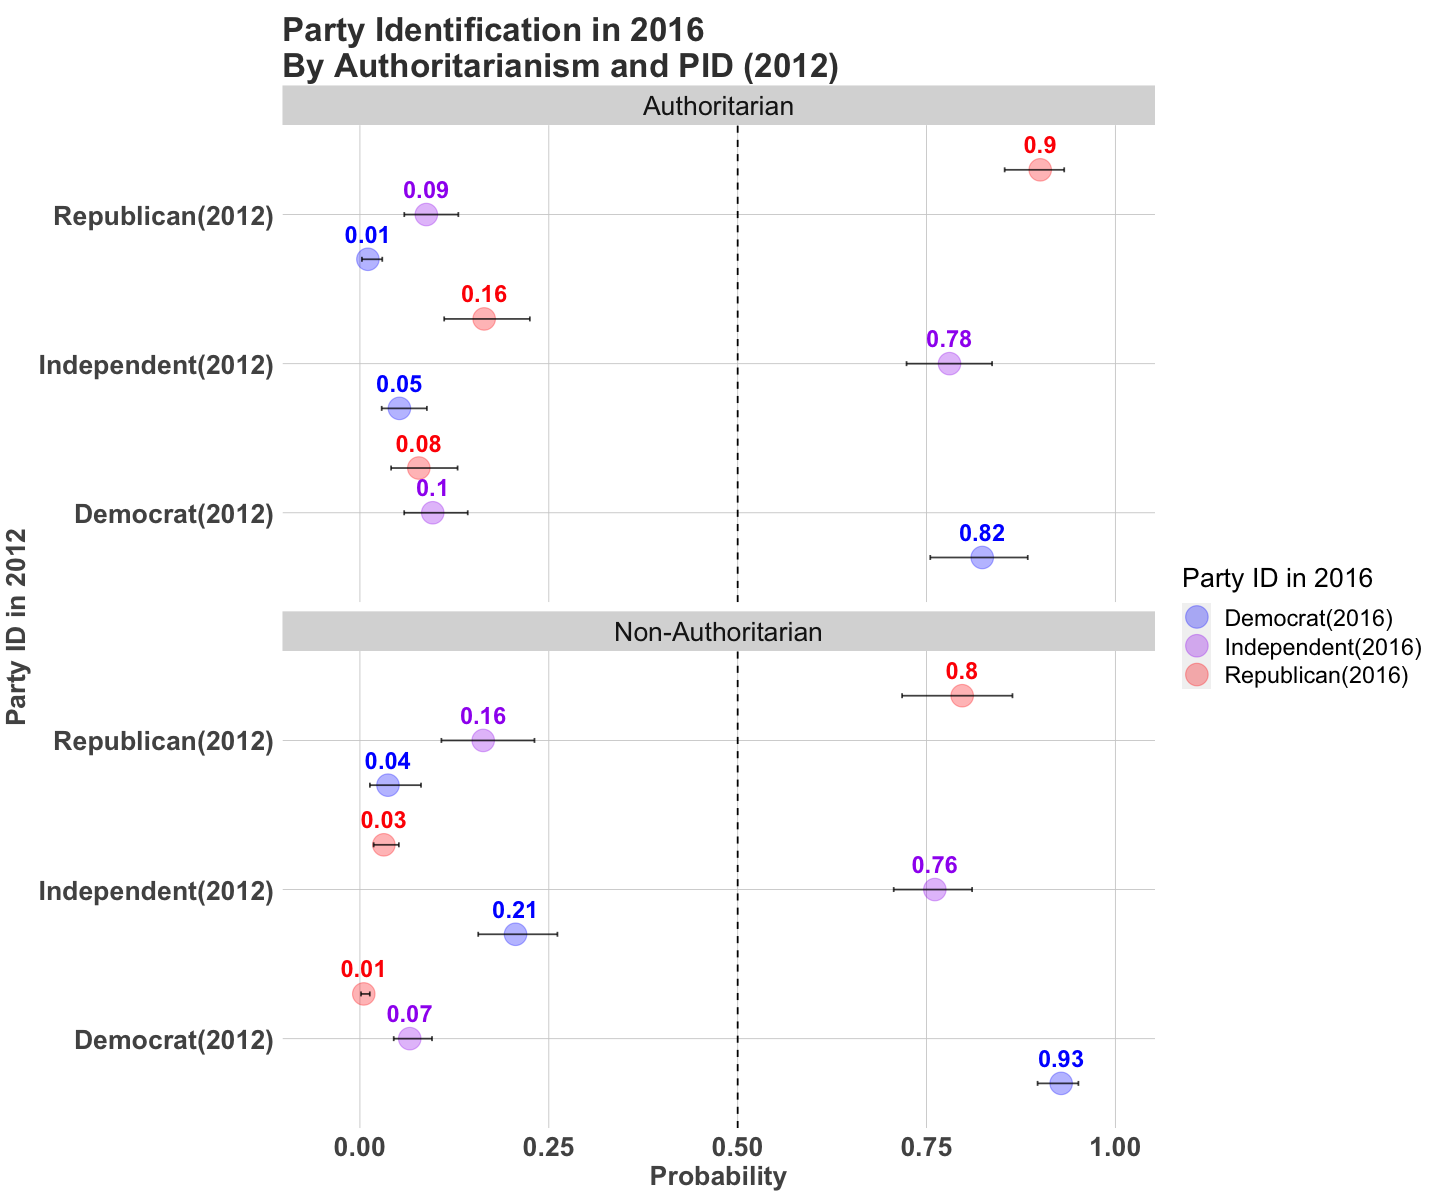

In [7]:
options(repr.plot.width=12, repr.plot.height=10)
#############################################################################################################################
zap_labels(dat2012) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2012 = mean(sex.2012, na.rm = T), age.2012 = mean(age.2012, na.rm = T), 
                       college.2012 = c(0,1), 
                       income.2012 = mean(income.2012, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       republican = c(0,1),
                       independent =c(0,1)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_epred_draws(dat[[5]]) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(outcome = recode(.category, `1` = "Democrat(2016)", `2` = "Independent(2016)", `3` = "Republican(2016)")) %>%
                       mutate(Partisanship = ifelse(republican == 0 & independent ==0, "Democrat(2012)", 
                                                ifelse(republican ==1 & independent ==0, "Republican(2012)",
                                                    "Independent(2012)")))  %>%
                      filter(!(republican ==1 & independent ==1)) %>% 

                       group_by(outcome, Authoritarianism, Partisanship) %>% 
                      summarize(mean = quantile(.epred, prob =  0.5),
                                min  = quantile(.epred, prob = 0.025),
                                max  = quantile(.epred, prob = 0.975)) %>% 
                                
 ggplot(aes(x = as.factor(Partisanship), 
                  y = mean, ymin=max, 
                  colour = outcome,
                  group = outcome,
                  ymax=min, label = round(mean,2)))+
facet_wrap(~ as.factor(Authoritarianism) , nrow = 4) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
  ggtitle("Party Identification in 2016\nBy Authoritarianism and PID (2012)") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("Party ID in 2012") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Party ID in 2016", values=c("blue", "purple", "red")) +
  coord_flip()   

`summarise()` has grouped output by 'outcome', 'Authoritarianism'. You can
override using the `.groups` argument.


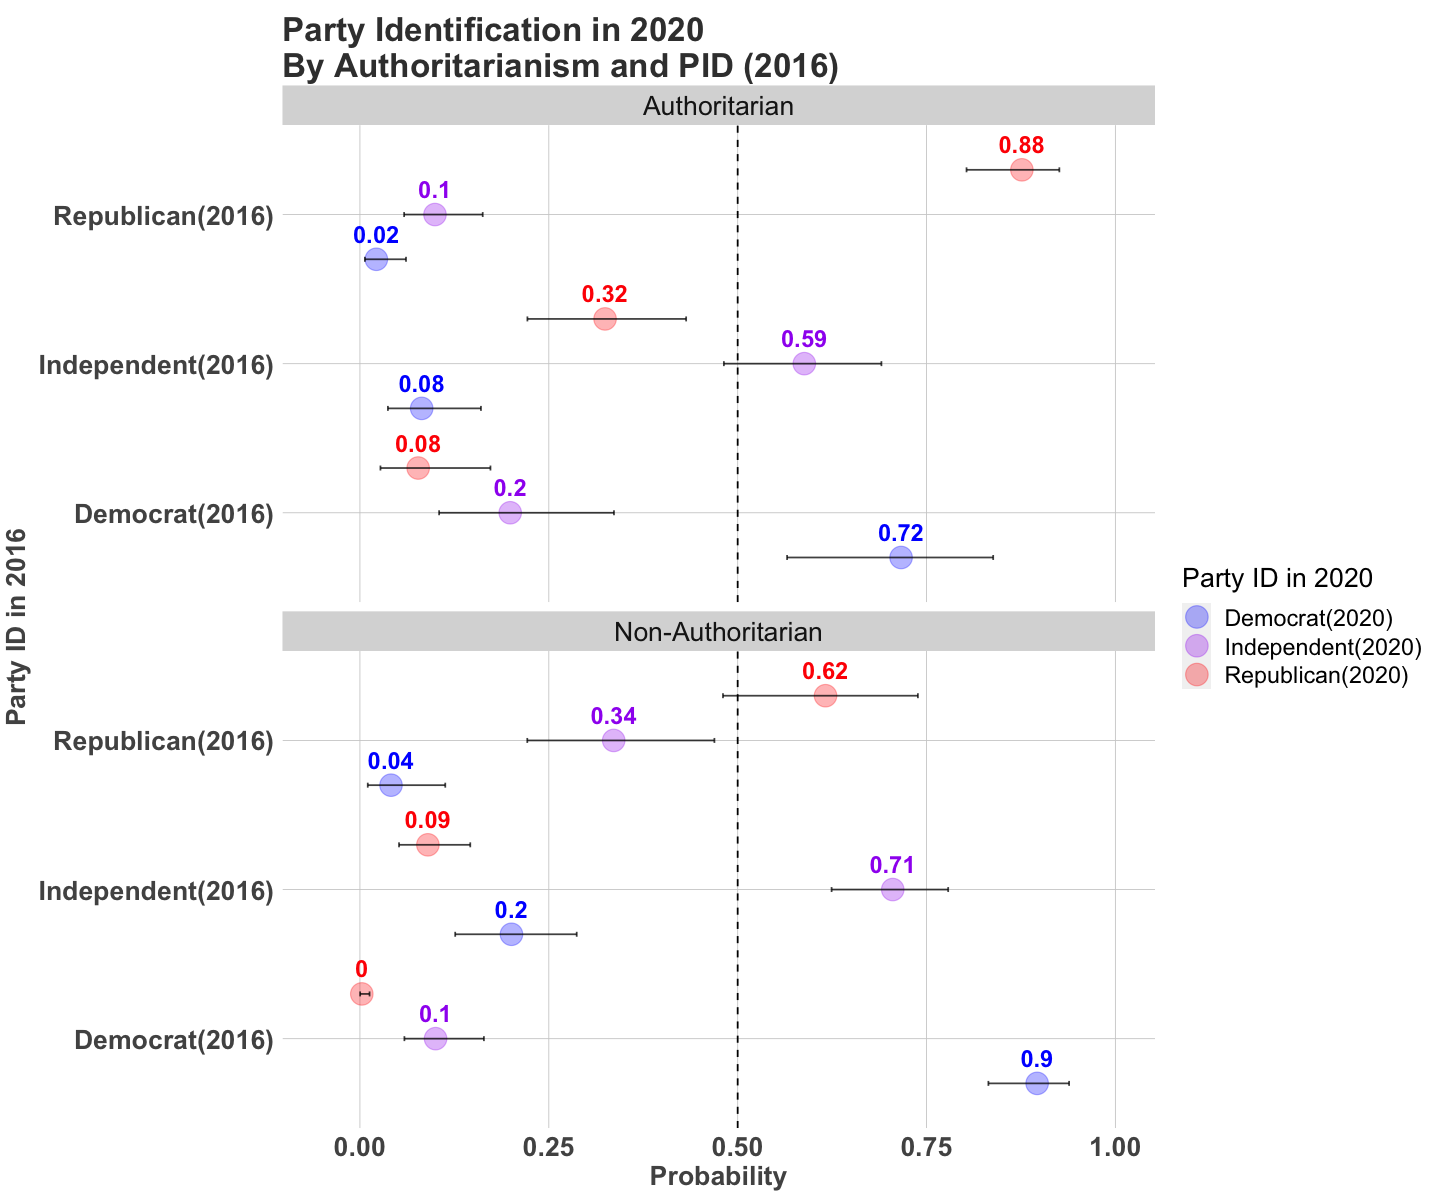

In [8]:
options(repr.plot.width=12, repr.plot.height=10)
#############################################################################################################################
zap_labels(dat2016) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(female.2016 = mean(female.2016, na.rm = T), age.2016 = mean(age.2016, na.rm = T), 
                       college.2016 = c(0,1), income.2016 = mean(income.2016, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       republican = c(0,1),
                       independent =c(0,1)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_epred_draws(dat[[6]]) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(outcome = recode(.category, `1` = "Democrat(2020)", `2` = "Independent(2020)", `3` = "Republican(2020)")) %>%
                       mutate(Partisanship = ifelse(republican == 0 & independent ==0, "Democrat(2016)", 
                                                ifelse(republican ==1 & independent ==0, "Republican(2016)",
                                                    "Independent(2016)")))  %>%
                      filter(!(republican ==1 & independent ==1)) %>% 
                       group_by(outcome, Authoritarianism, Partisanship) %>% 
                      summarize(mean = quantile(.epred, prob =  0.5),
                                min  = quantile(.epred, prob = 0.025),
                                max  = quantile(.epred, prob = 0.975)) %>% 
                                
                                
 ggplot(aes(x = as.factor(Partisanship), 
                  y = mean, ymin=max, 
                  colour = outcome,
                  group = outcome,
                  ymax=min, label = round(mean,2)))+
facet_wrap(~ as.factor(Authoritarianism) , nrow = 4) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
  ggtitle("Party Identification in 2020\nBy Authoritarianism and PID (2016)") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("Party ID in 2016") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Party ID in 2020", values=c("blue", "purple", "red")) +
  coord_flip()   




I'm happy to manually put this information in word -- a 2x2 transition matrix. However, I played around with the presentation below.  

# Voting

If voting is at the end of the chapter, it seems reasonable to combine years, though let me know if either of you believe this is problematic. It just seems that at the end of the chapter, the reader should be familiar with reading these results, voting is binary -- and even simpler to interpret -- and the chapter was already pretty dense. What I do below is produce the predictions for each year, and then combine into a large table called vote_choice_combined.



In [128]:
options(repr.plot.width=6, repr.plot.height=5)
plot_vote_2000 =zap_labels(dat2000) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2000 = mean(sex.2000, na.rm = T), age.2000 = mean(age.2000, na.rm = T), 
                       college.2000 = mean(college.2000, na.rm = T), income.2000 = mean(income.2000, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[1]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Voter = ifelse(vote1 == 1,  "Bush(2000)", "Gore(2000)")) %>% 
                       group_by(Voter, Authoritarianism) 
            # Hard coded: Be careful           
vote_2000 = rbind(
        plot_vote_2000     %>% group_by(Voter, Authoritarianism) %>%       
                                summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975)
                                ),
         plot_vote_2000     %>% group_by(Voter, Authoritarianism) %>%       
                                summarize(
                                mean = quantile(1 - Vote_Republican, prob =  0.5),
                                max  = quantile(1 - Vote_Republican, prob =  0.975),
                                min  = quantile(1 - Vote_Republican, prob = 0.025)
                                ))   %>% data.frame() %>% 
                             mutate(vote = rep(c("Bush(2004)", "Kerry(2004)"), each = 4)) 


`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.


In [127]:
library(tidyr)
paste("The probability of voting for Trump in 2016", "", "at high and low levels of authoritarianism  and 2012 vote choice:")
#############################################################################################################################
plot_vote_2012 = zap_labels(dat2012) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2012 = mean(sex.2012, na.rm = T), age.2012 = mean(age.2012, na.rm = T), 
                       college.2012 = mean(college.2012, na.rm = T), income.2012 = mean(income.2012, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[2]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Voter = ifelse(vote1 == 1,  "Romney(2012)", "Obama(2012)")) 

                       
            # Hard coded: Be careful           
vote_2012 = rbind(
        plot_vote_2012     %>% group_by(Voter, Authoritarianism) %>%       
                                summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975)
                                ),
         plot_vote_2012     %>% group_by(Voter, Authoritarianism) %>%       
                                summarize(
                                mean = quantile(1 - Vote_Republican, prob =  0.5),
                                max  = quantile(1 - Vote_Republican, prob =  0.975),
                                min  = quantile(1 - Vote_Republican, prob = 0.025)
                                ))   %>% data.frame() %>% 
                             mutate(vote = rep(c("Trump(2016)", "Clinton(2016)"), each = 4)) 

                            

[1] "The probability of voting for Trump in 2016  at high and low levels of authoritarianism  and 2012 vote choice:"

`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.


In [126]:
plot_vote_2016 = zap_labels(dat2016) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(female.2016 = mean(female.2016, na.rm = T), age.2016 = mean(age.2016, na.rm = T), 
                       college.2016 = mean(college.2016, na.rm = T), income.2016 = mean(income.2016, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[3]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Voter = ifelse(vote1 == 1,  "Trump(2016)", "Clinton(2016)")) %>% 
                       group_by(Voter, Authoritarianism) 
    
vote_2016 = rbind(
        plot_vote_2016     %>% group_by(Voter, Authoritarianism) %>%       
                                summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975)
                                ),
         plot_vote_2016     %>% group_by(Voter, Authoritarianism) %>%       
                                summarize(
                                mean = quantile(1 - Vote_Republican, prob =  0.5),
                                max  = quantile(1 - Vote_Republican, prob =  0.975),
                                min  = quantile(1 - Vote_Republican, prob = 0.025)
                                ))   %>% data.frame() %>% 
                             mutate(vote = rep(c("Trump(2020)", "Biden(2020)"), each = 4)) 


`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.


In [129]:
plot_dat = data.frame(rbind(vote_2000, vote_2012, vote_2016)) %>% 
            mutate(election_year = rep(c("2000-2004", "2012-2016", "2016-2020"), each = 8)) 
plot_dat

Voter,Authoritarianism,mean,min,max,vote,election_year
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Bush(2000),Authoritarian,0.94069299,0.815952016,0.98738604,Bush(2004),2000-2004
Bush(2000),Non-Authoritarian,0.91673938,0.816863389,0.97140350,Bush(2004),2000-2004
Gore(2000),Authoritarian,0.25949247,0.075068661,0.53570045,Bush(2004),2000-2004
Gore(2000),Non-Authoritarian,0.01767172,0.002970323,0.06959041,Bush(2004),2000-2004
Bush(2000),Authoritarian,0.05930701,0.012613964,0.18404798,Kerry(2004),2000-2004
Bush(2000),Non-Authoritarian,0.08326062,0.028596502,0.18313661,Kerry(2004),2000-2004
Gore(2000),Authoritarian,0.74050753,0.464299549,0.92493134,Kerry(2004),2000-2004
Gore(2000),Non-Authoritarian,0.98232828,0.930409589,0.99702968,Kerry(2004),2000-2004
Obama(2012),Authoritarian,0.21649649,0.163120798,0.28098316,Trump(2016),2012-2016


In [156]:
# This should be cleaned up, it combines plots in ggarrange
library(ggpubr)
options(repr.plot.width=8, repr.plot.height=6)

p1 = plot_dat %>% subset(election_year =="2000-2004") %>% 
ggplot(aes(x = as.factor(Voter), 
                  y = mean, ymin=max, 
                  colour = vote,
                  group = vote,
                  ymax=min, label = round(mean,2)))+
facet_wrap(~ as.factor(Authoritarianism) , nrow = 4) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
    ggtitle("Voting(2000-2004)") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("Vote in 2000") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Vote ", values=c("blue",  "red")) +
  coord_flip()  
 

p2 = plot_dat %>% subset(election_year =="2012-2016") %>% 
ggplot(aes(x = as.factor(Voter), 
                  y = mean, ymin=max, 
                  colour = vote,
                  group = vote,
                  ymax=min, label = round(mean,2)))+
facet_wrap(~ as.factor(Authoritarianism) , nrow = 4) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
  ggtitle("Voting(2012-2020)") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("Vote in 2012") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Vote ", values=c("blue",  "red")) +
  coord_flip()  

p3 = plot_dat %>% subset(election_year =="2016-2020") %>% 
ggplot(aes(x = as.factor(Voter), 
                  y = mean, ymin=max, 
                  colour = vote,
                  group = vote,
                  ymax=min, label = round(mean,2)))+
facet_wrap(~ as.factor(Authoritarianism) , nrow = 4) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
  ggtitle("Voting(2016-2020)") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("Vote in 2016") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Vote ", values=c("blue",  "red")) +
  coord_flip()  

  


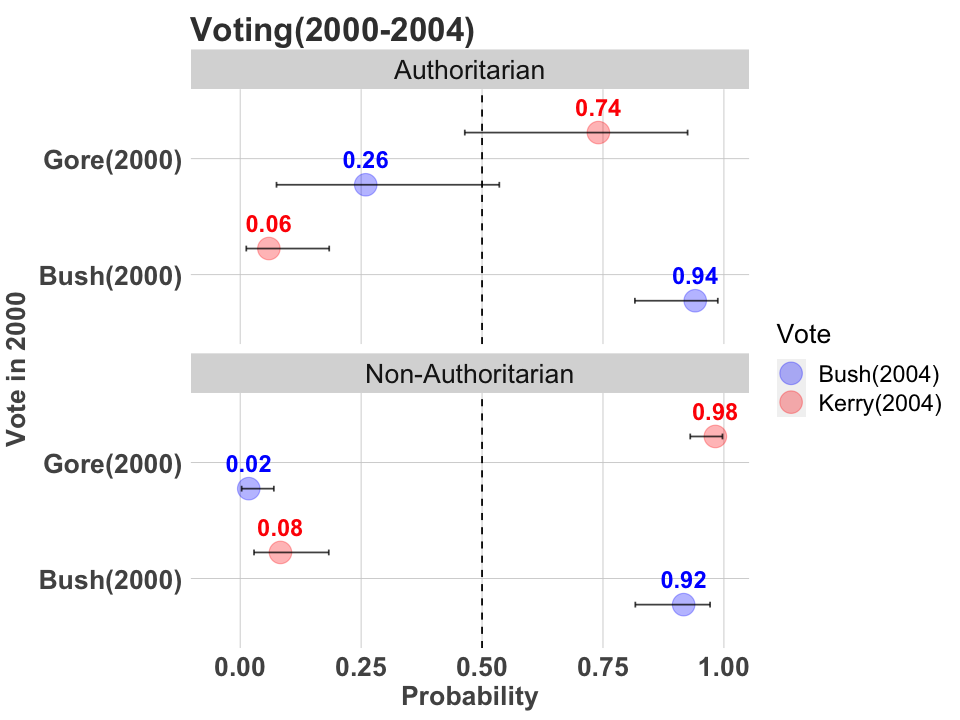

In [157]:
p1

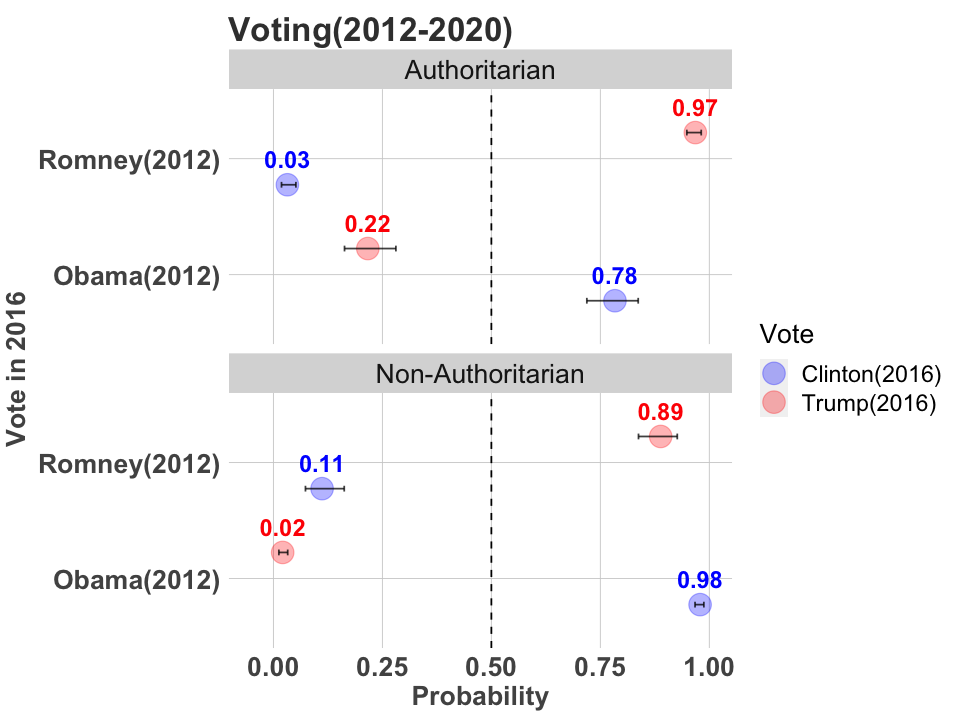

In [154]:
p2

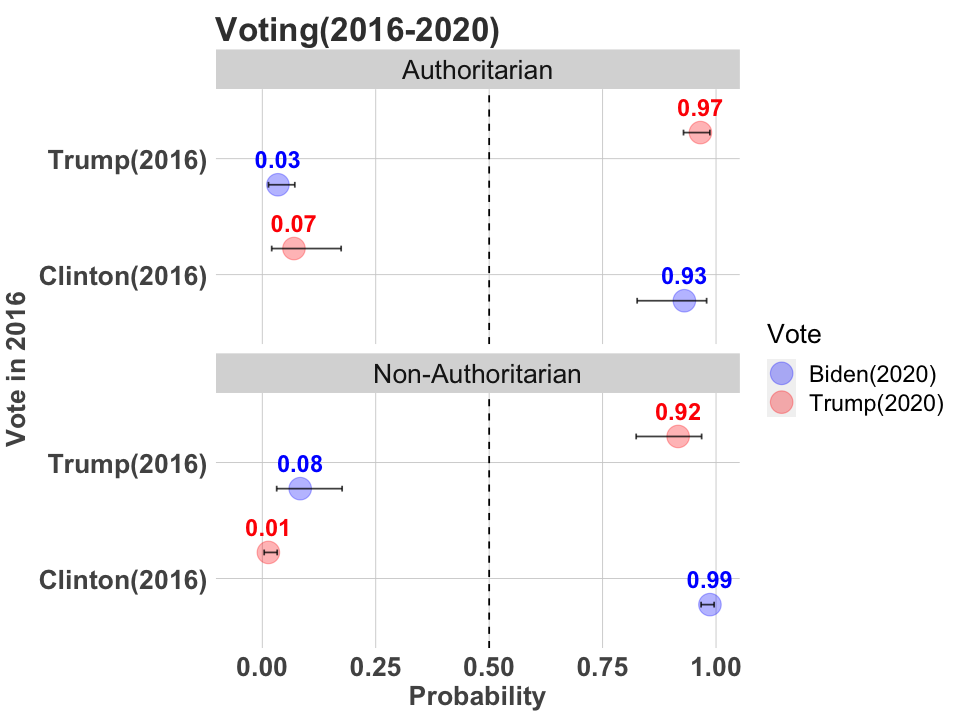

In [155]:
p3

`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.


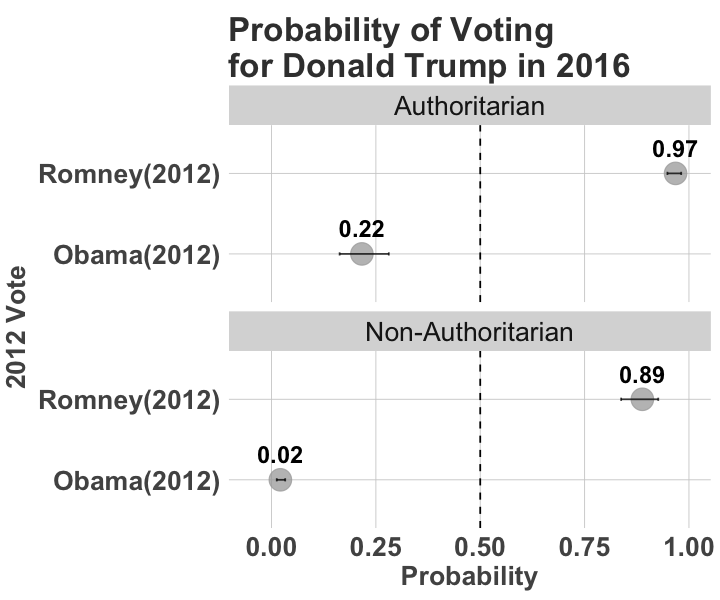

In [149]:
options(repr.plot.width=6, repr.plot.height=5)
#############################################################################################################################
p2 = zap_labels(dat2012) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2012 = mean(sex.2012, na.rm = T), age.2012 = mean(age.2012, na.rm = T), 
                       college.2012 = mean(college.2012, na.rm = T), income.2012 = mean(income.2012, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[2]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Voter = ifelse(vote1 == 1,  "Romney(2012)", "Obama(2012)")) %>% 
                       group_by(Voter, Authoritarianism) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975))%>%
ggplot(
              aes(x = as.factor(Voter), 
                  y = mean, ymin=max, 
                  ymax=min, label = round(mean,2)))+
  facet_wrap(~as.factor(Authoritarianism), nrow = 2) +
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.04, alpha=0.75, colour = "black") +
  ggtitle("Probability of Voting \nfor Donald Trump in 2016") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2012 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5)+
  coord_flip()
p2

In [25]:
options(repr.plot.width=6, repr.plot.height=8)
#############################################################################################################################
zap_labels(dat2016) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(female.2016 = mean(female.2016, na.rm = T), age.2016 = mean(age.2016, na.rm = T), 
                       college.2016 = mean(college.2016, na.rm = T), income.2016 = mean(income.2016, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[3]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Voter = ifelse(vote1 == 1,  "Trump(2016)", "Clinton(2016)")) %>% 
                       group_by(Voter, Authoritarianism) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975))

`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.


Voter,Authoritarianism,mean,min,max
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Clinton(2016),Authoritarian,0.06979170,0.020742794,0.17382555
Clinton(2016),Non-Authoritarian,0.01346249,0.004188302,0.03291888
Trump(2016),Authoritarian,0.96561237,0.928303427,0.98639757
Trump(2016),Non-Authoritarian,0.91644136,0.824018245,0.96826178


`summarise()` has grouped output by 'Voter'. You can override using the
`.groups` argument.


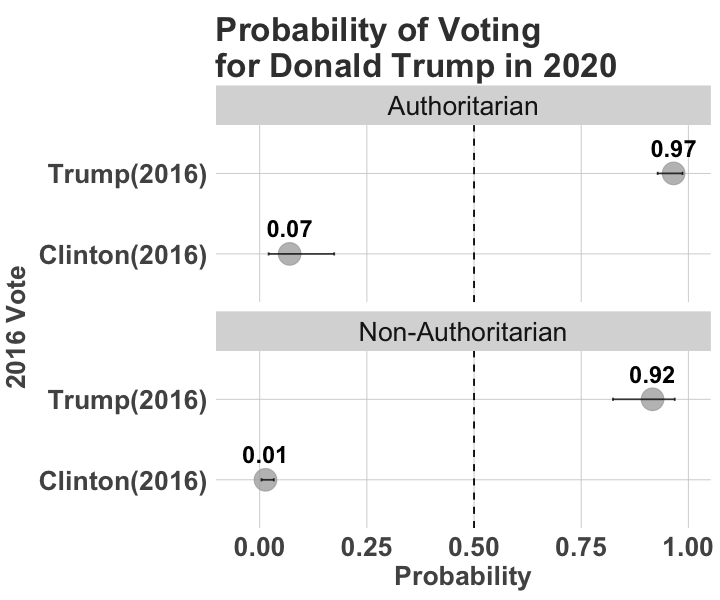

In [50]:
options(repr.plot.width=6, repr.plot.height=5)
#############################################################################################################################
p3 = zap_labels(dat2016) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(female.2016 = mean(female.2016, na.rm = T), age.2016 = mean(age.2016, na.rm = T), 
                       college.2016 = mean(college.2016, na.rm = T), income.2016 = mean(income.2016, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[3]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Voter = ifelse(vote1 == 1,  "Trump(2016)", "Clinton(2016)")) %>% 
                       group_by(Voter, Authoritarianism) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975)) %>% 
        ggplot(
              aes(x = as.factor(Voter), 
                  y = mean, ymin=max, 
                  ymax=min, label = round(mean,2)))+
  facet_wrap(~as.factor(Authoritarianism), nrow = 2) +
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.04, alpha=0.75, colour = "black") +
  ggtitle("Probability of Voting \nfor Donald Trump in 2020") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2016 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5)+
  coord_flip()
p3

# Education Effects

In [188]:
dat[[4]] %>% as.formula()
dat[[5]] %>% as.formula()
dat[[6]] %>% as.formula()

vote2 ~ sex.2000 + age.2000 + college.2000 + income.2000 + authoritarianism + authoritarianism_2 + vote1 + authoritarianism:vote1 + authoritarianism_2:vote1 + authoritarianism:college.2000 + authoritarianism_2:college.2000 + college.2000:vote1 + authoritarianism:college.2000:vote1 

vote2 ~ sex.2012 + age.2012 + college.2012 + income.2012 + authoritarianism + authoritarianism_2 + vote1 + authoritarianism:vote1 + authoritarianism_2:vote1 + authoritarianism:college.2012 + authoritarianism_2:college.2012 + college.2012:vote1 + authoritarianism:college.2012:vote1 

vote2 ~ female.2016 + age.2016 + college.2016 + income.2016 + authoritarianism + authoritarianism_2 + vote1 + authoritarianism:vote1 + authoritarianism_2:vote1 + authoritarianism:college.2016 + authoritarianism_2:college.2016 + college.2016:vote1 + authoritarianism:college.2016:vote1 

`summarise()` has grouped output by 'Voter', 'Authoritarianism'. You can
override using the `.groups` argument.


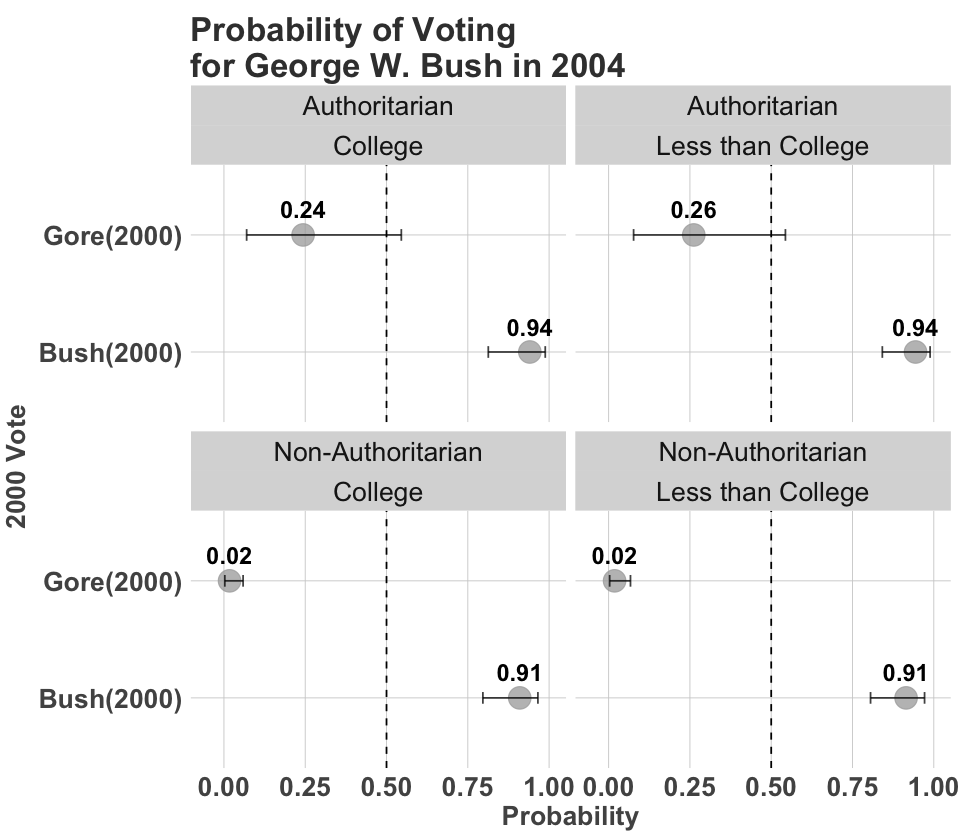

In [243]:
options(repr.plot.width=8, repr.plot.height=7)
zap_labels(dat2000) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2000 = mean(sex.2000, na.rm = T), age.2000 = mean(age.2000, na.rm = T), 
                       college.2000 = c(0, 1), 
                       income.2000 = mean(income.2000, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[1]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Voter = ifelse(vote1 == 1,  "Bush(2000)", "Gore(2000)")) %>% 
                       mutate(Education = ifelse(college.2000 == 1,  "College", "Less than College")) %>% 
                       group_by(Voter, Authoritarianism, Education) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975)) %>%
ggplot(
              aes(x = as.factor(Voter), 
                  y = mean, ymin=max, 
                  ymax=min, label = round(mean,2)))+
  facet_wrap(~as.factor(Authoritarianism) + Education, nrow = 2) +
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black") +
  ggtitle("Probability of Voting \nfor George W. Bush in 2004") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2000 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5)+
  coord_flip()

`summarise()` has grouped output by 'Voter', 'Authoritarianism'. You can
override using the `.groups` argument.


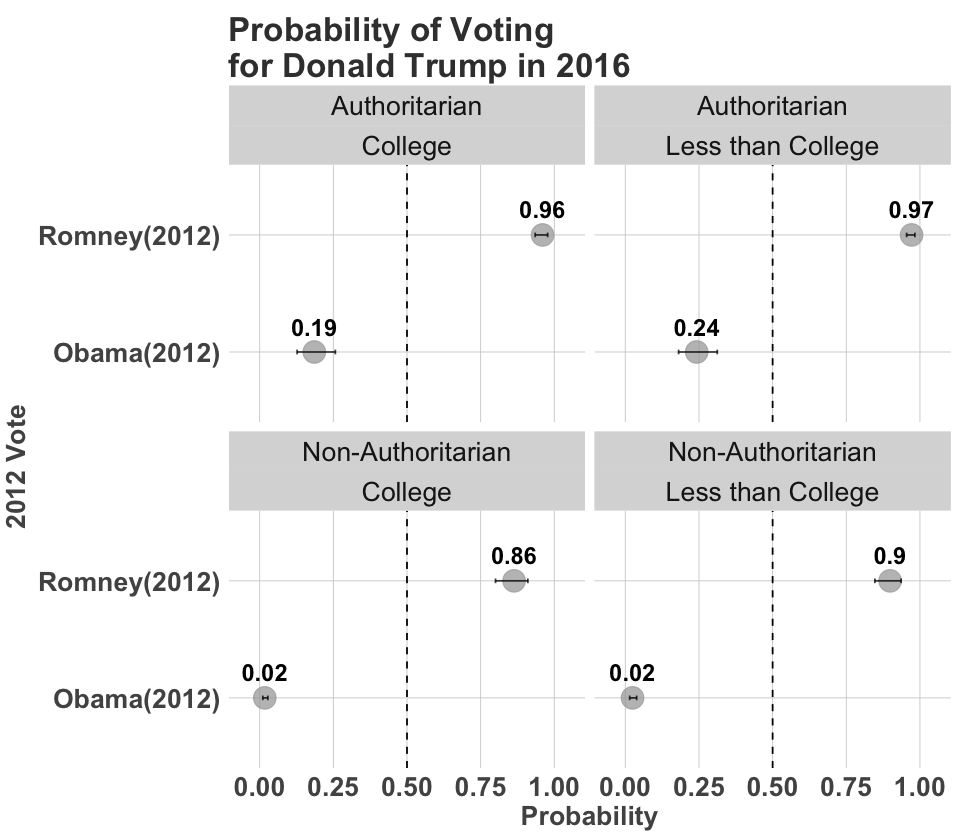

In [244]:
options(repr.plot.width=8, repr.plot.height=7)
#############################################################################################################################
zap_labels(dat2012) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2012 = mean(sex.2012, na.rm = T), age.2012 = mean(age.2012, na.rm = T), 
                       college.2012 = c(0,1), 
                       income.2012 = mean(income.2012, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[2]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Voter = ifelse(vote1 == 1,  "Romney(2012)", "Obama(2012)")) %>% 
                      mutate(Education = ifelse(college.2012 == 1,  "College", "Less than College")) %>% 
                       group_by(Voter, Authoritarianism, Education) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975))%>%
ggplot(
              aes(x = as.factor(Voter), 
                  y = mean, ymin=max, 
                  ymax=min, label = round(mean,2)))+
  facet_wrap(~as.factor(Authoritarianism) + Education, nrow = 2) +
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.04, alpha=0.75, colour = "black") +
  ggtitle("Probability of Voting \nfor Donald Trump in 2016") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1.05))+
  scale_x_discrete("2012 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5)+
  coord_flip()

`summarise()` has grouped output by 'Voter', 'Authoritarianism'. You can
override using the `.groups` argument.


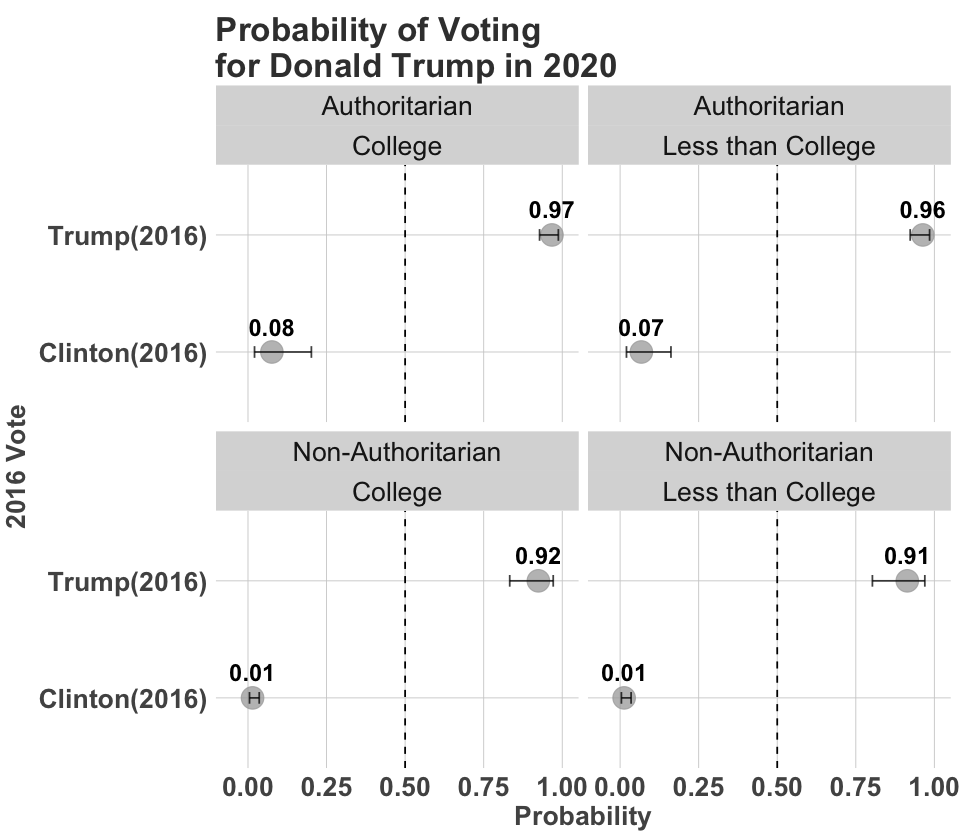

In [ ]:
options(repr.plot.width=8, repr.plot.height=7)
#############################################################################################################################
zap_labels(dat2016) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(female.2016 = mean(female.2016, na.rm = T), age.2016 = mean(age.2016, na.rm = T), 
                       college.2016 = c(0,1), income.2016 = mean(income.2016, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       vote1 = seq_range(vote1, n = 2)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_linpred_draws(dat[[3]]) %>% 
                       mutate(Vote_Republican = plogis(.linpred)) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(Education = ifelse(college.2016 == 1,  "College", "Less than College")) %>% 
                       mutate(Voter = ifelse(vote1 == 1,  "Trump(2016)", "Clinton(2016)")) %>% 
                       group_by(Voter, Authoritarianism, Education) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975)) %>% 
ggplot(
              aes(x = as.factor(Voter), 
                  y = mean, ymin=max, 
                  ymax=min, colour = college,
                  group = college,  label = round(mean,2)))+
  facet_wrap(~as.factor(Authoritarianism), nrow = 2) +
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black") +
  ggtitle("Probability of Voting \nfor Donald Trump in 2020") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2016 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5)+
  coord_flip()

# Party Identification

In [10]:
dat[[4]]%>% as.formula
dat[[5]]%>% as.formula
dat[[6]]%>% as.formula

pid3.2 ~ sex.2000 + age.2000 + college.2000 + income.2000 + authoritarianism + authoritarianism_2 + republican + independent + authoritarianism:republican + authoritarianism_2:republican + authoritarianism:independent + authoritarianism_2:independent 

pid3.2 ~ sex.2012 + sex.2012 + college.2012 + income.2012 + authoritarianism + authoritarianism_2 + republican + independent + authoritarianism:republican + authoritarianism_2:republican + authoritarianism:independent + authoritarianism_2:independent 

pid3.2 ~ female.2016 + age.2016 + college.2016 + income.2016 + authoritarianism + authoritarianism_2 + republican + independent + authoritarianism:republican + authoritarianism_2:republican + authoritarianism:independent + authoritarianism_2:independent 

In [249]:
options(repr.plot.width=8, repr.plot.height=8)
#############################################################################################################################
zap_labels(dat2012) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2012 = mean(sex.2012, na.rm = T), age.2012 = mean(age.2012, na.rm = T), 
                       college.2012 = c(0,1), 
                       income.2012 = mean(income.2012, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       republican = c(0,1),
                       independent =c(0,1)) %>% 
                       filter(!(republican ==1 & independent ==1)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_epred_draws(dat[[2]]) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(outcome = recode(.category, `1` = "Democrat(2016)", `2` = "Independent(2016)", `3` = "Republican(2016)")) %>%
                       mutate(Partisanship = ifelse(republican == 0 & independent ==0, "Democrat(2012)", 
                                                ifelse(republican ==1 & independent ==0, "Republican(2012)",
                                                    "Independent(2012)")))  %>%
                       group_by(outcome, Authoritarianism, Partisanship) %>% 
                      summarize(mean = quantile(.epred, prob =  0.5),
                                min  = quantile(.epred, prob = 0.025),
                                max  = quantile(.epred, prob = 0.975)) 

`summarise()` has grouped output by 'outcome', 'Authoritarianism'. You can
override using the `.groups` argument.


outcome,Authoritarianism,Partisanship,mean,min,max
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Democrat(2016),Authoritarian,Democrat(2012),0.823513297,0.755423471,0.88416542
Democrat(2016),Authoritarian,Independent(2012),0.052944072,0.028880527,0.09038869
Democrat(2016),Authoritarian,Republican(2012),0.010755980,0.003025619,0.02835875
Democrat(2016),Non-Authoritarian,Democrat(2012),0.927937493,0.896059666,0.95039273
Democrat(2016),Non-Authoritarian,Independent(2012),0.207431618,0.156541561,0.25990661
Democrat(2016),Non-Authoritarian,Republican(2012),0.036098863,0.013170613,0.08016778
Independent(2016),Authoritarian,Democrat(2012),0.096050689,0.059423525,0.14276324
Independent(2016),Authoritarian,Independent(2012),0.781349916,0.721325628,0.83555119
Independent(2016),Authoritarian,Republican(2012),0.088040775,0.059298498,0.12851268


`summarise()` has grouped output by 'outcome', 'Authoritarianism'. You can
override using the `.groups` argument.


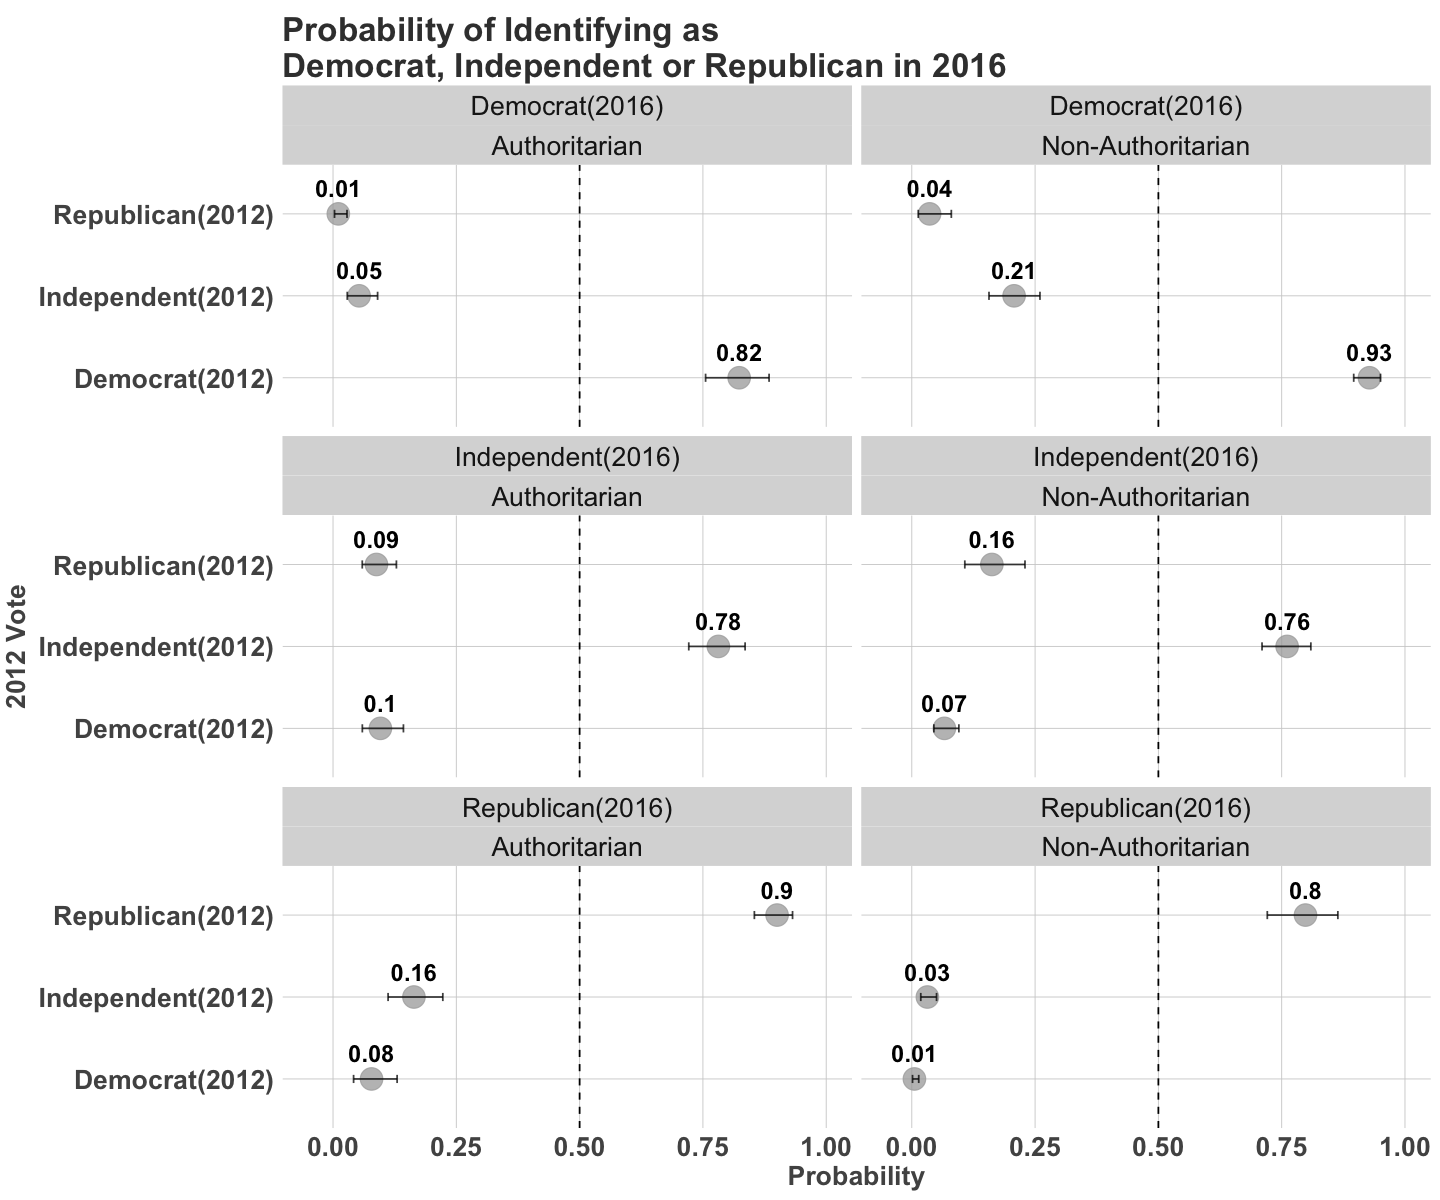

In [250]:
options(repr.plot.width=12, repr.plot.height=10)
#############################################################################################################################
zap_labels(dat2012) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2012 = mean(sex.2012, na.rm = T), age.2012 = mean(age.2012, na.rm = T), 
                       college.2012 = c(0,1), 
                       income.2012 = mean(income.2012, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       republican = c(0,1),
                       independent =c(0,1)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_epred_draws(dat[[2]]) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(outcome = recode(.category, `1` = "Democrat(2016)", `2` = "Independent(2016)", `3` = "Republican(2016)")) %>%
                       mutate(Partisanship = ifelse(republican == 0 & independent ==0, "Democrat(2012)", 
                                                ifelse(republican ==1 & independent ==0, "Republican(2012)",
                                                    "Independent(2012)")))  %>%
                      filter(!(republican ==1 & independent ==1)) %>% 

                       group_by(outcome, Authoritarianism, Partisanship) %>% 
                      summarize(mean = quantile(.epred, prob =  0.5),
                                min  = quantile(.epred, prob = 0.025),
                                max  = quantile(.epred, prob = 0.975)) %>% 
                                
ggplot(
              aes(x = Partisanship, 
                  y = mean, ymin=max, 
                  ymax=min, 
                  label = round(mean,2)))+
  facet_wrap(~as.factor(outcome) + as.factor(Authoritarianism), nrow = 3) +
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black") +
  ggtitle("Probability of Identifying as\nDemocrat, Independent or Republican in 2016") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2012 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5)+
  coord_flip()

### 2012-2016 Panel

`summarise()` has grouped output by 'outcome', 'Authoritarianism'. You can
override using the `.groups` argument.


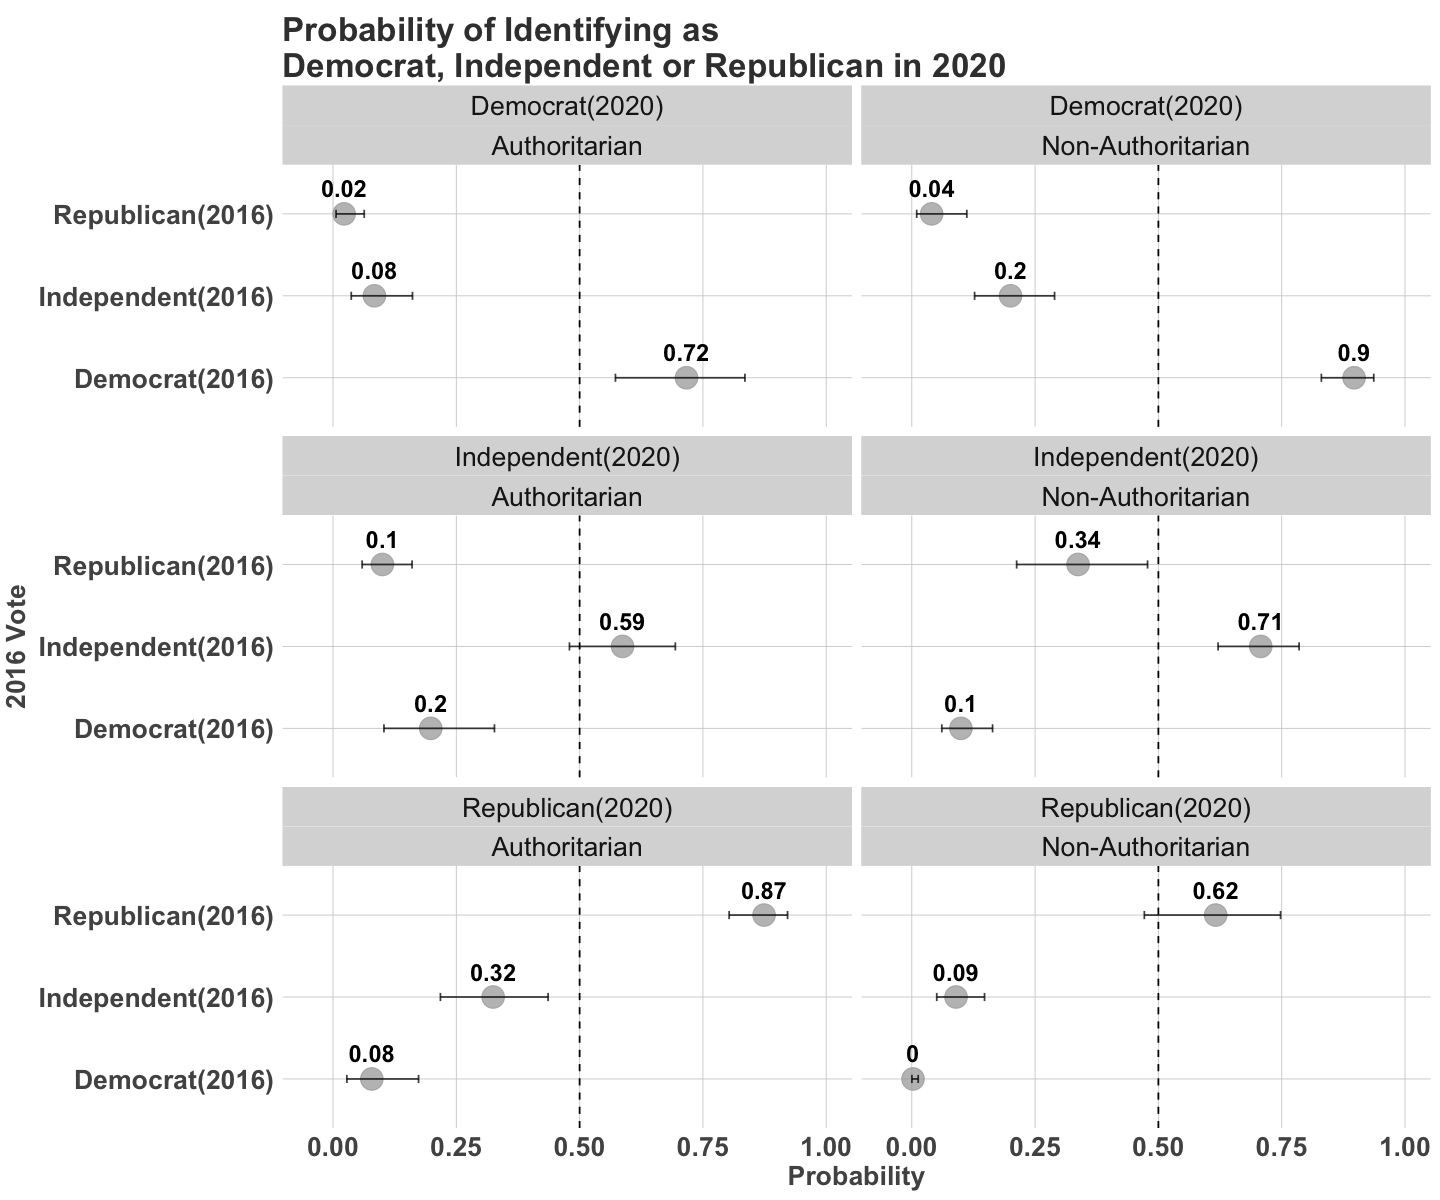

In [251]:
options(repr.plot.width=12, repr.plot.height=10)
#############################################################################################################################
zap_labels(dat2016) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(female.2016 = mean(female.2016, na.rm = T), age.2016 = mean(age.2016, na.rm = T), 
                       college.2016 = c(0,1), income.2016 = mean(income.2016, na.rm = T), 
                       authoritarianism = seq_range(authoritarianism, n = 2),
                       republican = c(0,1),
                       independent =c(0,1)) %>% 
                       mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                       add_epred_draws(dat[[3]]) %>% 
                       mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                       mutate(outcome = recode(.category, `1` = "Democrat(2020)", `2` = "Independent(2020)", `3` = "Republican(2020)")) %>%
                       mutate(Partisanship = ifelse(republican == 0 & independent ==0, "Democrat(2016)", 
                                                ifelse(republican ==1 & independent ==0, "Republican(2016)",
                                                    "Independent(2016)")))  %>%
                      filter(!(republican ==1 & independent ==1)) %>% 
                       group_by(outcome, Authoritarianism, Partisanship) %>% 
                      summarize(mean = quantile(.epred, prob =  0.5),
                                min  = quantile(.epred, prob = 0.025),
                                max  = quantile(.epred, prob = 0.975)) %>% 
                                
ggplot(
              aes(x = Partisanship, 
                  y = mean, ymin=max, 
                  ymax=min, 
                  label = round(mean,2)))+
  facet_wrap(~as.factor(outcome) + as.factor(Authoritarianism), nrow = 3) +
  geom_point(size=6, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black") +
  ggtitle("Probability of Identifying as\nDemocrat, Independent or Republican in 2020") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2016 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5)+
  coord_flip()

# Cohort analysis

This analysis is pretty intereresting. We can't say much about 2000-2004 -- there just isn't enough data. So, I'll just focus on 2012-2016 and 2016-2020 -- i.e., Trump led conversion.

The cohort analysis is important, I think, as we can't say a whole lot about what kinds of authoritarians are changing. 

In [280]:
## Print the six cohort models
## 3 years (1-3: No three way interaction; 4-6 three way interaction)
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapters/Chapter7/chapter7_cohorts.rda")
for(i in 1:6)
    print(dat[[i]]%>% as.formula)

vote2 ~ sex.2000 + age.2000 + college.2000 + income.2000 + authoritarianism + authoritarianism_2 + boomer + gen_x + vote1 + authoritarianism:vote1 + authoritarianism_2:vote1 + vote1:boomer + vote1:boomer + authoritarianism:boomer + authoritarianism_2:boomer + authoritarianism:gen_x + authoritarianism_2:gen_x 
vote2 ~ sex.2012 + age.2012 + college.2012 + income.2012 + authoritarianism + authoritarianism_2 + boomer + gen_x + vote1 + authoritarianism:vote1 + authoritarianism_2:vote1 + vote1:boomer + vote1:boomer + vote1:gen_x + vote1:millenial + authoritarianism:boomer + authoritarianism_2:boomer + authoritarianism:gen_x + authoritarianism_2:gen_x + authoritarianism:millenial + authoritarianism_2:millenial 
vote2 ~ female.2016 + age.2016 + college.2016 + income.2016 + authoritarianism + authoritarianism_2 + boomer + gen_x + vote1 + authoritarianism:vote1 + authoritarianism_2:vote1 + vote1:boomer + vote1:boomer + vote1:gen_x + authoritarianism:boomer + authoritarianism_2:boomer + authorita

In [266]:
options(repr.plot.width=8, repr.plot.height=7)
zap_labels(dat2000) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2000 = mean(sex.2000, na.rm = T), 
                      age.2000 = mean(age.2000, na.rm = T), 
                      college.2000 = mean(college.2000, na.rm = T), 
                      income.2000 = mean(income.2000, na.rm = T), 
                      authoritarianism = seq_range(authoritarianism, n = 2),
                      vote1 = seq_range(vote1, n = 2),
                      boomer = c(0,1),
                      gen_x = c(0,1),
                      ) %>% 
                      filter(!(boomer ==1 & gen_x ==1)) %>%
                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                      add_linpred_draws(dat[[1]]) %>% 
                      mutate(Vote_Republican = plogis(.linpred)) %>% 
                      mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                      mutate(Voter = ifelse(vote1 == 1,  "Bush(2000)", "Gore(2000)")) %>% 
                      mutate(generation = ifelse(boomer == 1, "Boomer", 
                                            ifelse(gen_x ==1, "Generation X", "Greatest/Silent"))) %>%
                      group_by(Voter, Authoritarianism, generation) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975)) 
                    

`summarise()` has grouped output by 'Voter', 'Authoritarianism'. You can
override using the `.groups` argument.


Voter,Authoritarianism,generation,mean,min,max
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Bush(2000),Authoritarian,Boomer,0.98936550,0.8827356240,0.99968416
Bush(2000),Authoritarian,Generation X,0.99835481,0.7705961977,0.99999969
Bush(2000),Authoritarian,Greatest/Silent,0.90801452,0.6511137153,0.98778016
Bush(2000),Non-Authoritarian,Boomer,0.94321243,0.8076193453,0.99150027
Bush(2000),Non-Authoritarian,Generation X,0.91217724,0.5205590337,0.99470457
Bush(2000),Non-Authoritarian,Greatest/Silent,0.90068474,0.6971981041,0.98148663
Gore(2000),Authoritarian,Boomer,0.30779958,0.0686512322,0.70089225
Gore(2000),Authoritarian,Generation X,0.90969438,0.0492052624,0.99997653
Gore(2000),Authoritarian,Greatest/Silent,0.15952115,0.0150307355,0.60388943


`summarise()` has grouped output by 'Voter', 'Authoritarianism'. You can
override using the `.groups` argument.


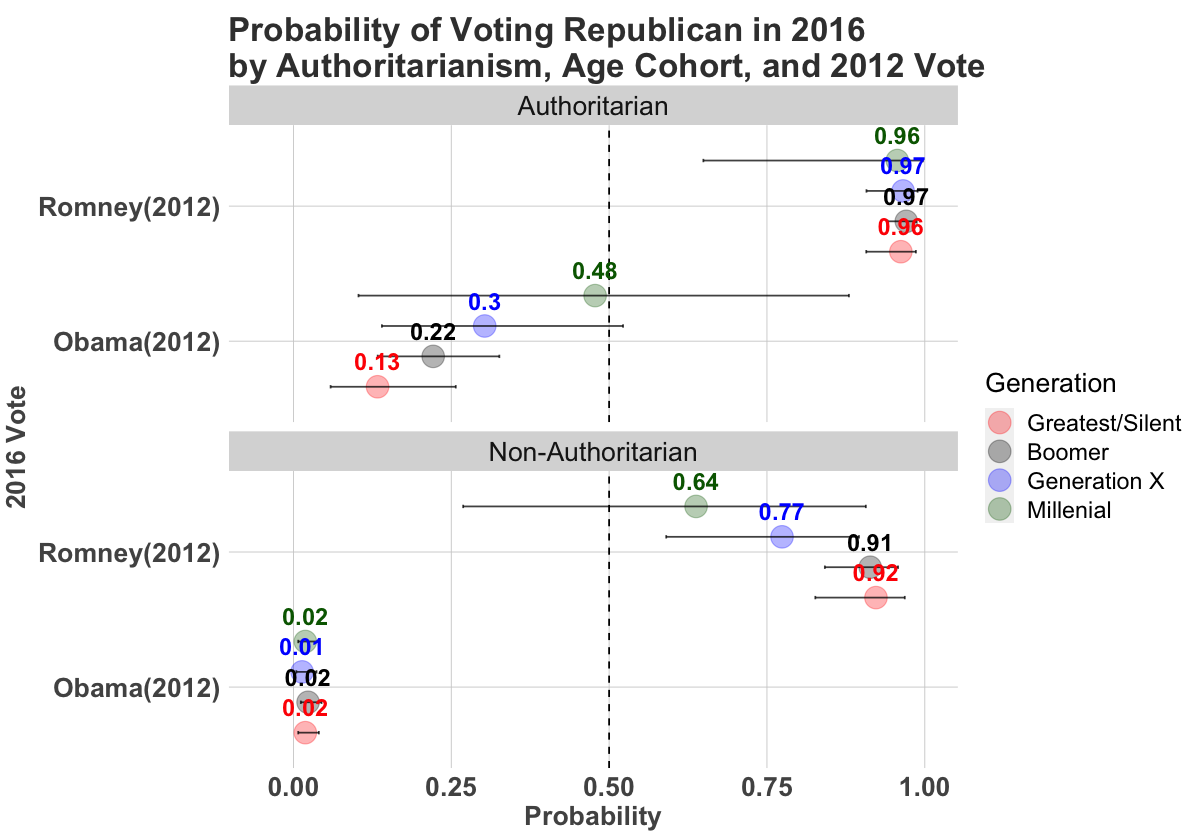

In [321]:
options(repr.plot.width=10, repr.plot.height=7)
zap_labels(dat2012) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2012 = mean(sex.2012, na.rm = T), 
                      age.2012 = mean(age.2012, na.rm = T), 
                      college.2012 = c(0,1), 
                      income.2012 = mean(income.2012, na.rm = T), 
                      authoritarianism = seq_range(authoritarianism, n = 2),
                      vote1 = seq_range(vote1, n = 2),
                      boomer = c(0,1),
                      gen_x = c(0,1),
                      millenial = c(0, 1),
                      ) %>% 
                      filter(!(boomer ==1 & gen_x ==1)) %>%
                      filter(!(boomer ==1 & millenial ==1)) %>%
                      filter(!(gen_x ==1  & millenial ==1)) %>%
                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                      add_linpred_draws(dat[[2]]) %>% 
                      mutate(Vote_Republican = plogis(.linpred)) %>% 
                      mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                      mutate(Voter = ifelse(vote1 == 1,  "Romney(2012)", "Obama(2012)")) %>% 
                      mutate(generation = ifelse(boomer == 1, "Boomer", 
                                            ifelse(gen_x ==1, "Generation X", 
                                                ifelse(millenial ==1, "Millenial", "Greatest/Silent"))) %>% as.factor()) %>%
                      group_by(Voter, Authoritarianism, generation) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975))  %>% 
                    mutate(generation = factor(generation, levels=c('Greatest/Silent', 'Boomer', 'Generation X', "Millenial"))) %>%

 ggplot(
              aes(x = Voter, 
                  y = mean, ymin=max, 
                  ymax=min, group = generation,
                  color = generation,
                  label = round(mean,2)))+
  facet_wrap(~ as.factor(Authoritarianism) + , nrow = 4) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
  ggtitle("Probability of Voting Republican in 2016\nby Authoritarianism, Age Cohort, and 2012 Vote") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2016 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Generation", values=c("red", "black", "blue", "darkgreen")) +
  coord_flip()     

There's a great amount of uncertainty, volatility among Millenial voters. They are most likely to change -- authoritarians and non-authoritarians alike. Look at the "stickiness" for the GOP -- non-authoritarians of all generations are more likely to consistently vote Republican than are their authoritarian counterparts. 

`summarise()` has grouped output by 'Voter', 'Authoritarianism'. You can
override using the `.groups` argument.


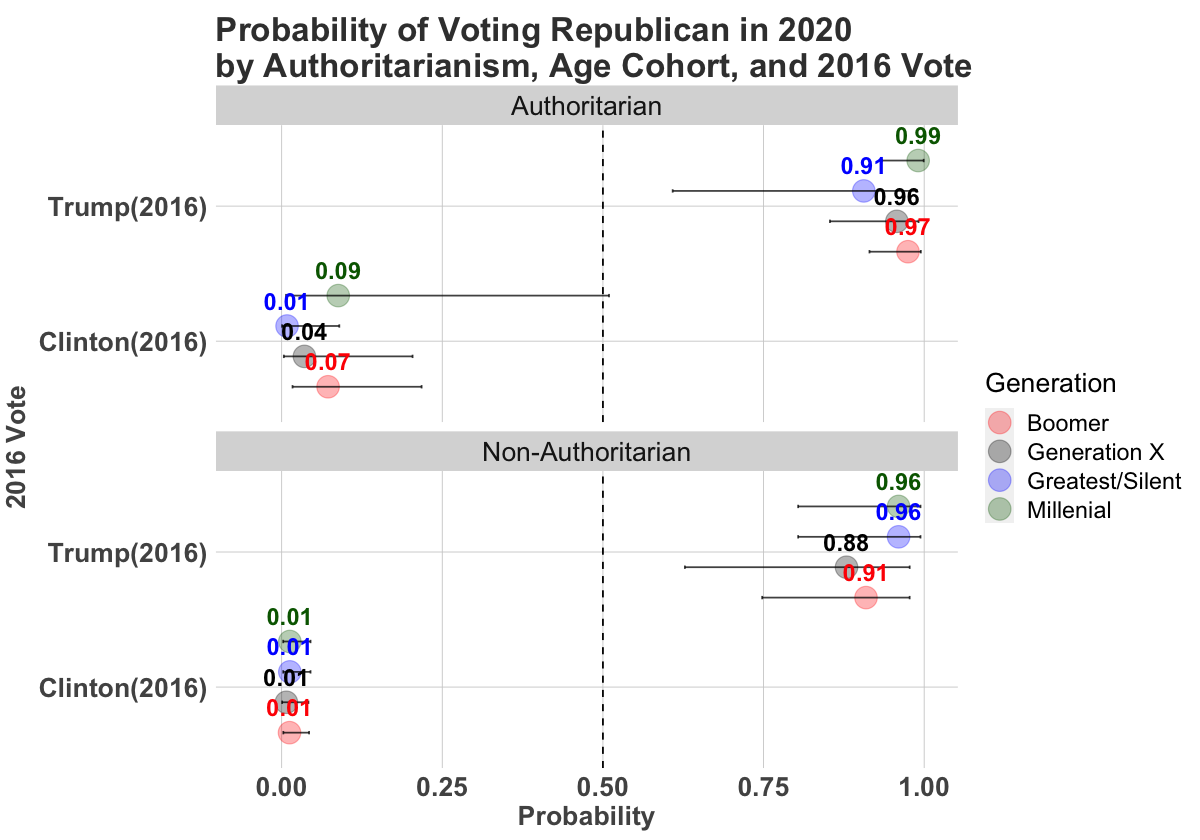

In [323]:
options(repr.plot.width=10, repr.plot.height=7)
zap_labels(dat2016) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(female.2016 = mean(female.2016, na.rm = T), 
                      age.2016 = mean(age.2016, na.rm = T), 
                      college.2016 = c(0,1), 
                      income.2016 = mean(income.2016, na.rm = T), 
                      authoritarianism = seq_range(authoritarianism, n = 2),
                      vote1 = seq_range(vote1, n = 2),
                      boomer = c(0,1),
                      gen_x = c(0,1),
                      millenial = c(0, 1),
                      ) %>% 
                      filter(!(boomer ==1 & gen_x ==1)) %>%
                      filter(!(boomer ==1 & millenial ==1)) %>%
                      filter(!(gen_x ==1  & millenial ==1)) %>%
                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                      add_linpred_draws(dat[[3]]) %>% 
                      mutate(Vote_Republican = plogis(.linpred)) %>% 
                      mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                      mutate(Voter = ifelse(vote1 == 1,  "Trump(2016)", "Clinton(2016)")) %>% 
                      mutate(generation = ifelse(boomer == 1, "Boomer", 
                                            ifelse(gen_x ==1, "Generation X", 
                                                ifelse(millenial ==1, "Millenial", "Greatest/Silent")))) %>%
                      group_by(Voter, Authoritarianism, generation) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975)) %>% 
   ggplot(
              aes(x = Voter, 
                  y = mean, ymin=max, 
                  ymax=min, group = generation,
                  color = generation,
                  label = round(mean,2)))+
  facet_wrap(~ as.factor(Authoritarianism), nrow = 4) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
  ggtitle("Probability of Voting Republican in 2020\nby Authoritarianism, Age Cohort, and 2016 Vote") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2016 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Generation", values=c("red", "black", "blue", "darkgreen")) +
  coord_flip()  

No real age cohort x education effects.

`summarise()` has grouped output by 'Voter', 'Authoritarianism', 'generation'.
You can override using the `.groups` argument.


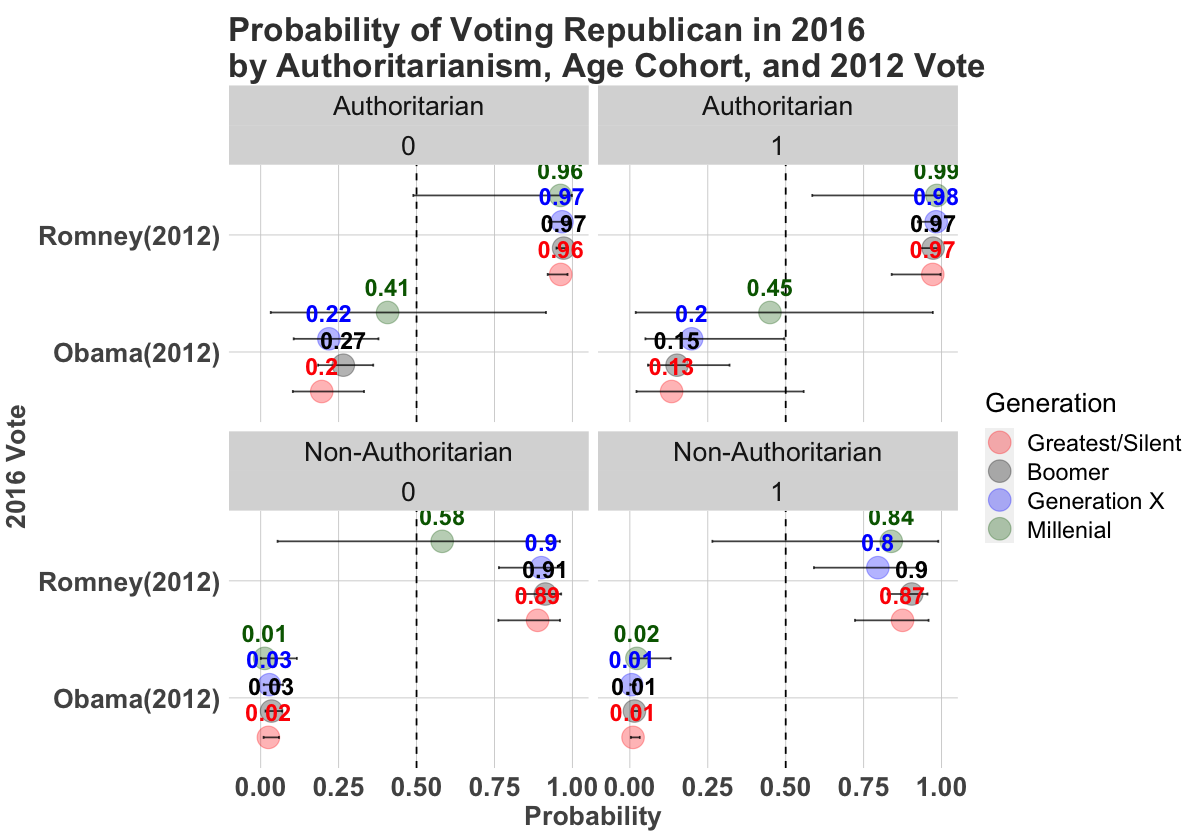

In [328]:
options(repr.plot.width=10, repr.plot.height=7)
zap_labels(dat2012) %>%  mutate(vote1 = as.vector(vote1)) %>%
            data_grid(sex.2012 = mean(sex.2012, na.rm = T), 
                      age.2012 = mean(age.2012, na.rm = T), 
                      college.2012 = c(0,1), 
                      income.2012 = mean(income.2012, na.rm = T), 
                      authoritarianism = seq_range(authoritarianism, n = 2),
                      vote1 = seq_range(vote1, n = 2),
                      boomer = c(0,1),
                      gen_x = c(0,1),
                      millenial = c(0, 1),
                      ) %>% 
                      filter(!(boomer ==1 & gen_x ==1)) %>%
                      filter(!(boomer ==1 & millenial ==1)) %>%
                      filter(!(gen_x ==1  & millenial ==1)) %>%
                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                      add_linpred_draws(dat[[5]]) %>% 
                      mutate(Vote_Republican = plogis(.linpred)) %>% 
                      mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
                      mutate(Voter = ifelse(vote1 == 1,  "Romney(2012)", "Obama(2012)")) %>% 
                      mutate(generation = ifelse(boomer == 1, "Boomer", 
                                            ifelse(gen_x ==1, "Generation X", 
                                                ifelse(millenial ==1, "Millenial", "Greatest/Silent"))) %>% as.factor()) %>%
                      group_by(Voter, Authoritarianism, generation, college.2012) %>% 
                      summarize(mean = quantile(Vote_Republican, prob =  0.5),
                                min  = quantile(Vote_Republican, prob = 0.025),
                                max  = quantile(Vote_Republican, prob = 0.975))  %>% 
                    mutate(generation = factor(generation, levels=c('Greatest/Silent', 'Boomer', 'Generation X', "Millenial"))) %>%

 ggplot(
              aes(x = Voter, 
                  y = mean, ymin=max, 
                  ymax=min, group = generation,
                  color = generation,
                  label = round(mean,2)))+
  facet_wrap(~ as.factor(Authoritarianism) + college.2012) +
  geom_point(size=6, alpha = 0.3, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.10, alpha=0.75, colour = "black", position = position_dodge(width = 0.9)) +
  ggtitle("Probability of Voting Republican in 2016\nby Authoritarianism, Age Cohort, and 2012 Vote") +
  ggtheme + 
  scale_y_continuous("Probability", limits=c(-0.05,1))+
  scale_x_discrete("2016 Vote") + 
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") + 
  geom_text(aes(fontface = 2), vjust = -1, size = 5, position = position_dodge(width = 0.9), show.legend = FALSE)+
  scale_colour_manual(name="Generation", values=c("red", "black", "blue", "darkgreen")) +
  coord_flip()     